In [41]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [42]:
# Load the growth factor and forex data
growth_data = pd.read_csv('/Users/miaxiaozile/Downloads/$/forex-project/data/growth.csv')
forex_data = pd.read_csv('/Users/miaxiaozile/Downloads/$/forex-project/data/fx_yoy.csv')

growth_data = growth_data.set_index('Unnamed: 0')
growth_data.index = pd.to_datetime(growth_data.index).to_period('M')
forex_data = forex_data.set_index('Unnamed: 0')
forex_data.index = pd.to_datetime(forex_data.index).to_period('M')


In [43]:
# Combine the growth factor with the forex rate data
data = pd.merge(growth_data, forex_data, left_index=True, right_index=True)
data.index.name="Date"
data.index = data.index.to_timestamp()

In [44]:
# Ensure data is stationary
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value for {name}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')

# Initial ADF test
adf_test(data['growth'], 'Growth')
adf_test(data['USD/CNY Central Parity Rate'], 'USD/CNY Central Parity Rate')

ADF Statistic for Growth: -2.2604233308647768
p-value for Growth: 0.18504998322840488
Critical Values 1%: -3.472161410886292
Critical Values 5%: -2.8798954259680936
Critical Values 10%: -2.5765565828092245
ADF Statistic for USD/CNY Central Parity Rate: -2.9671768801717007
p-value for USD/CNY Central Parity Rate: 0.03807545103485297
Critical Values 1%: -3.4718957209472654
Critical Values 5%: -2.8797795410156253
Critical Values 10%: -2.5764947265625


In [45]:
# Define time series split
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_lag = 0

# Hyperparameter tuning for lag order using cross-validation
for lag in range(1, 16):
    mse_list = []
    for train_index, test_index in tscv.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model = VAR(train)
        result = model.fit(lag)
        forecast = result.forecast(train.values[-lag:], steps=len(test))
        forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)
        mse = mean_squared_error(test['USD/CNY Central Parity Rate'], forecast_df['USD/CNY Central Parity Rate'])
        mse_list.append(mse)
    
    avg_mse = np.mean(mse_list)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_lag = lag

print(f'Best Lag Order based on Cross-Validation: {best_lag}, Best MSE: {best_mse}')

Best Lag Order based on Cross-Validation: 15, Best MSE: 27.83304561304926


In [46]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Fit the VAR model with the best lag order and include a trend
model = VAR(train_data)
result = model.fit(best_lag, trend='ct')  # You can try 'ct' or 'ctt' for trend inclusion
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Jul, 2024
Time:                     18:07:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.90335
Nobs:                     124.000    HQIC:                   4.03903
Log likelihood:          -501.655    FPE:                    32.1880
AIC:                      3.44772    Det(Omega_mle):         20.3371
--------------------------------------------------------------------
Results for equation growth
                                     coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------
const                                  -2.245614         1.785036           -1.258           0.208
trend                                   0.014657         0.017039            0.860    

In [47]:
# Forecasting
forecast_steps = len(test_data)
forecast = result.forecast(train_data.values[-best_lag:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=train_data.columns)

# Calculate the mean squared error for the forex rate
mse = mean_squared_error(test_data['USD/CNY Central Parity Rate'], forecast_df['USD/CNY Central Parity Rate'])
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 24.726812130602067


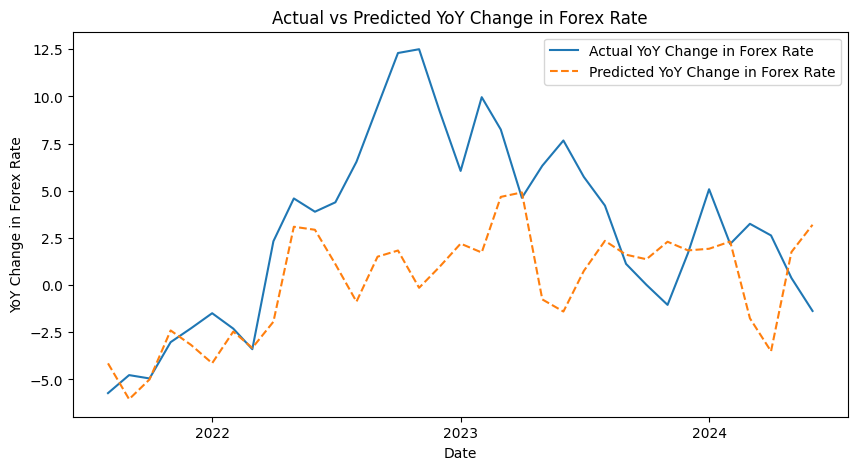

In [48]:
# Plot the actual vs predicted forex rates
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data['USD/CNY Central Parity Rate'], label='Actual YoY Change in Forex Rate')
plt.plot(forecast_df.index, forecast_df['USD/CNY Central Parity Rate'], label='Predicted YoY Change in Forex Rate', linestyle='--')

# Set major locator and formatter to display only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add legend, title, and labels
plt.legend()
plt.title('Actual vs Predicted YoY Change in Forex Rate')
plt.xlabel('Date')
plt.ylabel('YoY Change in Forex Rate')
plt.show()

In [49]:
# Convert forecast_df index to period for further processing
forecast_df.index = forecast_df.index.to_period('M')

# Load the actual data
actual_data = pd.read_csv('/Users/miaxiaozile/Downloads/$/forex-project/data/fx.csv').set_index('Unnamed: 0')
actual_data.index.name = "Date"
actual_data.index = pd.to_datetime(actual_data.index)
actual_data.index = actual_data.index.to_period('M')

# Determine the start of the forecast period
start_forecast_period = forecast_df.index.min()

# Ensure that the actual data includes the 12 months leading up to the forecast period
required_start_date = start_forecast_period - 12

# Filter the actual data to include the required period
extended_actual_data = actual_data.loc[required_start_date:]

# Ensure that the predicted YoY changes and the actual data overlap correctly
overlap_index = extended_actual_data.index.intersection(forecast_df.index)
aligned_actual = extended_actual_data.loc[overlap_index]
aligned_predicted_yoy = forecast_df.loc[overlap_index]

In [50]:
# Initialize the list with the first actual value (12 months prior to the forecast start)
predicted_actual_values = []

# Loop through the predicted YoY changes starting from the 12th month
for i in range(len(aligned_predicted_yoy)):
    prev_value = extended_actual_data['USD/CNY Central Parity Rate'].iloc[i]
    change = aligned_predicted_yoy['USD/CNY Central Parity Rate'].iloc[i]
    new_value = prev_value * (1 + change / 100)
    predicted_actual_values.append(new_value)

# Create a DataFrame for the predicted actual values
predicted_actual_df = pd.DataFrame(predicted_actual_values, index=aligned_predicted_yoy.index, columns=['Predicted USD/CNY Central Parity Rate'])

In [51]:
# Convert the period index back to a datetime index for plotting
aligned_actual.index = aligned_actual.index.to_timestamp()
predicted_actual_df.index = predicted_actual_df.index.to_timestamp()

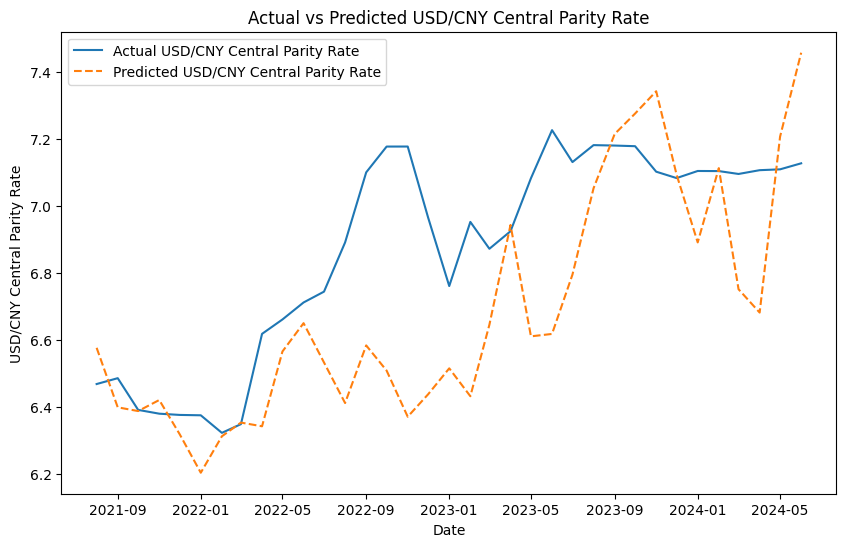

In [52]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(aligned_actual['USD/CNY Central Parity Rate'], label='Actual USD/CNY Central Parity Rate')
plt.plot(predicted_actual_df['Predicted USD/CNY Central Parity Rate'], label='Predicted USD/CNY Central Parity Rate', linestyle='--')
plt.title('Actual vs Predicted USD/CNY Central Parity Rate')
plt.xlabel('Date')
plt.ylabel('USD/CNY Central Parity Rate')
plt.legend()
plt.show()

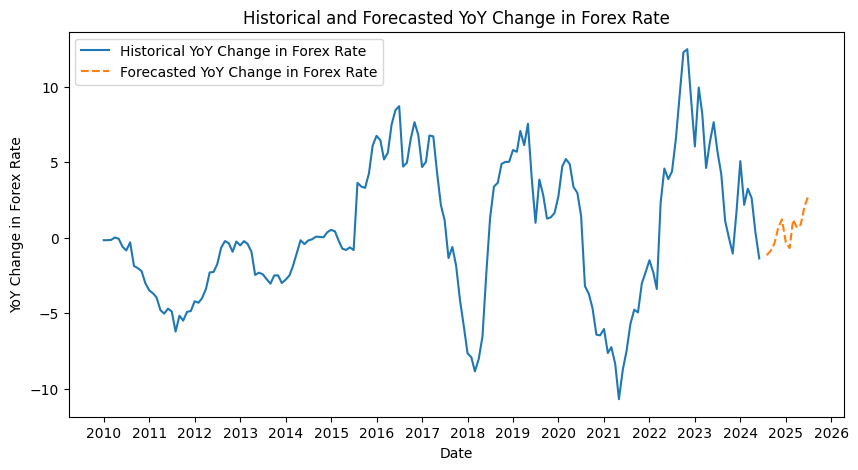

In [53]:
# Fit the VAR model with the best lag order on the entire dataset
model = VAR(data)
result = model.fit(best_lag, trend='ct')

# Forecast future values (next 12 months)
future_forecast_steps = 12  # Number of months to forecast
future_forecast = result.forecast(data.values[-best_lag:], steps=future_forecast_steps)
future_forecast_df = pd.DataFrame(future_forecast, index=pd.date_range(start=data.index[-1] + pd.offsets.MonthBegin(1), periods=future_forecast_steps, freq='M'), columns=data.columns)

# Plot the forecasted forex rates
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['USD/CNY Central Parity Rate'], label='Historical YoY Change in Forex Rate')
plt.plot(future_forecast_df.index, future_forecast_df['USD/CNY Central Parity Rate'], label='Forecasted YoY Change in Forex Rate', linestyle='--')

# Set major locator and formatter to display only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add legend, title, and labels
plt.legend()
plt.title('Historical and Forecasted YoY Change in Forex Rate')
plt.xlabel('Date')
plt.ylabel('YoY Change in Forex Rate')
plt.show()

In [57]:
future_forecast_df

,growth,USD/CNY Central Parity Rate
2024-07-31,8.046509,-1.155725
2024-08-31,6.465142,-0.872844
2024-09-30,8.785054,-0.394854
2024-10-31,8.663094,0.646311
2024-11-30,6.078578,1.218376
2024-12-31,5.417549,-0.283631
2025-01-31,8.028040,-0.686380
2025-02-28,6.844473,1.200392
2025-03-31,6.689994,0.666988
2025-04-30,8.717101,0.870247


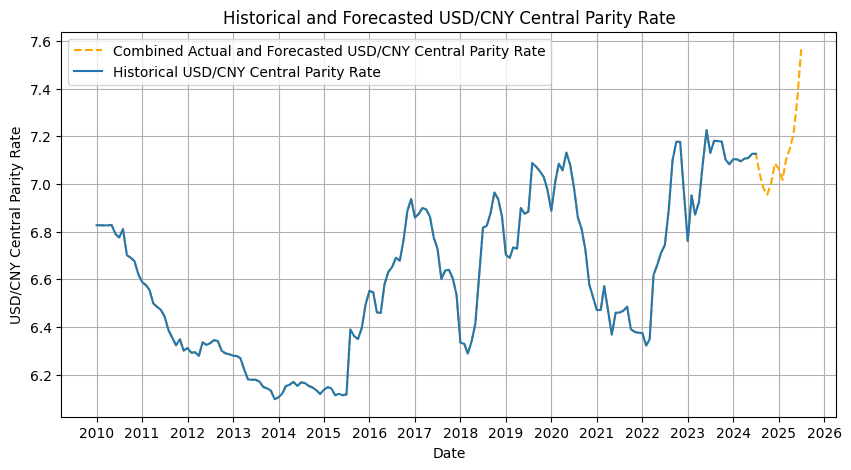

In [54]:
# Initialize the list with the last actual value from actual_data
last_actual_value = actual_data['USD/CNY Central Parity Rate'].iloc[-1]
forecasted_actual_values = [last_actual_value]

# Loop through the predicted YoY changes to calculate actual forecasted values
for i in range(len(future_forecast_df)):
    change = future_forecast_df['USD/CNY Central Parity Rate'].iloc[i]
    new_value = forecasted_actual_values[-1] * (1 + change / 100)
    forecasted_actual_values.append(new_value)

# Remove the first value as it is the last actual value
forecasted_actual_values = forecasted_actual_values[1:]

# Create a DataFrame for the forecasted actual values
forecasted_actual_df = pd.DataFrame(forecasted_actual_values, index=future_forecast_df.index, columns=['Forecasted USD/CNY Central Parity Rate'])

# Convert the index of actual_data to datetime if it's in period format
if isinstance(actual_data.index, pd.PeriodIndex):
    actual_data.index = actual_data.index.to_timestamp()

# Plot the historical actual values and the forecasted actual values
plt.figure(figsize=(10, 5))
# plt.plot(forecasted_actual_df.index, forecasted_actual_df['Forecasted USD/CNY Central Parity Rate'], label='Forecasted USD/CNY Central Parity Rate', linestyle='--')

# Combine the historical data and forecasted data to create a continuous line
combined_values = pd.concat([actual_data['USD/CNY Central Parity Rate'], forecasted_actual_df['Forecasted USD/CNY Central Parity Rate']])
plt.plot(combined_values.index, combined_values, linestyle='--', color='orange', label='Combined Actual and Forecasted USD/CNY Central Parity Rate')
plt.plot(actual_data.index, actual_data['USD/CNY Central Parity Rate'], label='Historical USD/CNY Central Parity Rate')


# Set major locator and formatter to display only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add legend, title, and labels
plt.legend()
plt.grid()
plt.title('Historical and Forecasted USD/CNY Central Parity Rate')
plt.xlabel('Date')
plt.ylabel('USD/CNY Central Parity Rate')
plt.show()

In [55]:
combined_values.to_csv("/Users/miaxiaozile/Downloads/$/forex-project/data/growth_pred.csv", header=True)